In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np
from matplotlib import pyplot as plt

In [0]:
to_tensor = transforms.ToTensor()
to_image = transforms.ToPILImage()

train_set = MNIST('./', download=True, transform=to_tensor)
train_loader = DataLoader(train_set, shuffle=True, batch_size=128)

In [0]:
class VAE(nn.Module):
    
    def __init__(self, n_input=784, n_hidden=256, n_latent=2):
        super(VAE, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_latent = n_latent
        self.encoder = nn.Sequential(
                            nn.Linear(self.n_input, self.n_hidden),
                            nn.ReLU(),
                        )
        self.z_mean = nn.Linear(self.n_hidden, self.n_latent)
        self.z_log_sigma = nn.Linear(self.n_hidden, self.n_latent)
        self.decoder = nn.Sequential(
                            nn.Linear(self.n_latent, self.n_hidden),
                            nn.ReLU(),
                            nn.Linear(self.n_hidden, self.n_input),
                            nn.Sigmoid()
                        )


    def sample(self, mu, log_sigma):
        sigma = torch.exp(log_sigma/2)
        epsilon = torch.rand_like(sigma)
        return mu + epsilon * sigma

    
    def forward(self, x):
        x = x.view(-1, self.n_input)
        x = self.encoder(x)
        mu = self.z_mean(x)
        log_sigma = self.z_log_sigma(x)
        z = self.sample(mu, log_sigma)
        y = self.decoder(z)
        return y, mu, log_sigma

In [0]:
def VAELoss(y, x, mu, log_sigma):
    KLdiv = -0.5*(1+log_sigma-mu.pow(2)-log_sigma.exp()).sum()
    recon_loss = nn.BCELoss(reduction='sum')(y, x)
    return KLdiv + recon_loss

In [0]:
vae = VAE(784,256,2).cuda()
optimizer = optim.Adam(vae.parameters())
epochs = 40

In [0]:
for epoch in range(epochs):
    
    total_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.view(-1,784).cuda()
        optimizer.zero_grad()
        y, mu, log_sigma = vae(x)
        loss = VAELoss(y, x, mu, log_sigma)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    
    print('Epoch: {} Loss: {}'.format(epoch, total_loss/len(train_loader.dataset)))

In [0]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = torch.Tensor([[xi, yi]]).cuda()
        x_decoded = vae.decoder(z_sample).cpu().detach().numpy()
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

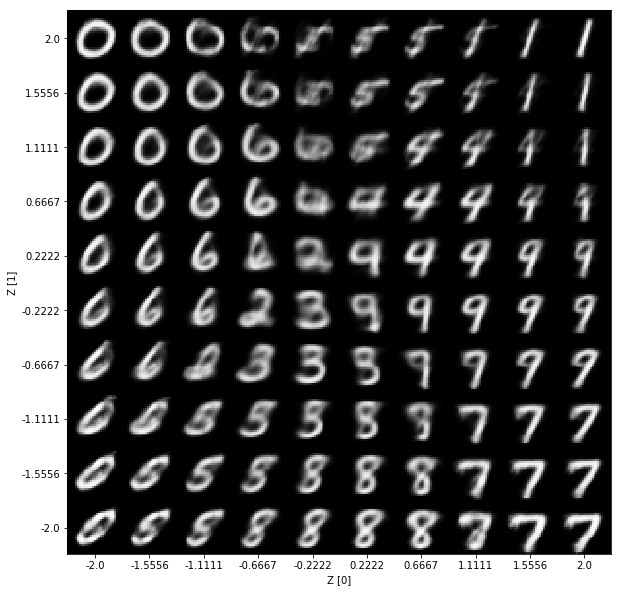

In [77]:
plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 4)
sample_range_y = np.round(grid_y, 4)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("Z [0]")
plt.ylabel("Z [1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig('fig.jpg')
plt.show()

In [0]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), 'sample.png')